Once deleted, variables cannot be recovered. Proceed (y/[n])? y


/home/wa_ziqia/miniconda3/envs/deepl2023/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/wa_ziqia/miniconda3/envs/deepl2023/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Image: https://github.com/ajschumacher/imagen/raw/master/imagen/n01776313_1303_tick.jpg
Prediction:  78: 'tick',
Score: 0.8674294948577881


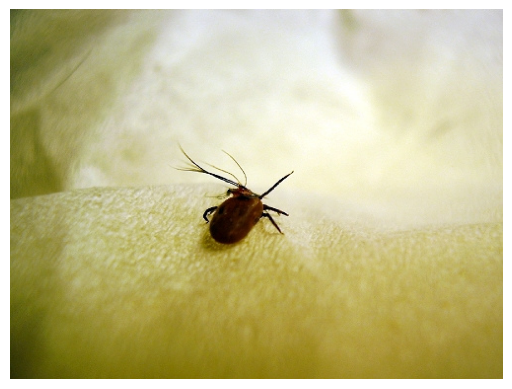

Image: https://github.com/ajschumacher/imagen/raw/master/imagen/n01443537_2625_goldfish.jpg
Prediction:  1: 'goldfish, Carassius auratus',
Score: 0.8977013826370239


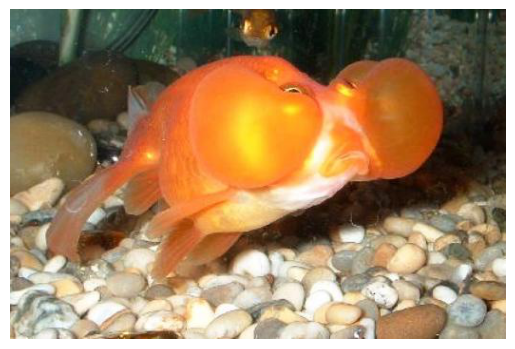

Image: https://github.com/ajschumacher/imagen/raw/master/imagen/n01944390_3990_snail.jpg
Prediction:  113: 'snail',
Score: 0.5390090346336365


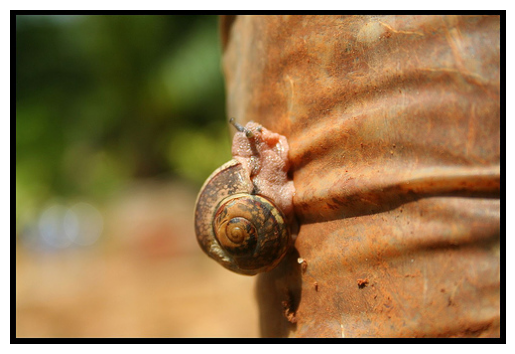

In [194]:
%reset
import torch
import urllib.request
from PIL import Image
from torchvision import models, transforms
import requests
from io import BytesIO
import matplotlib.pyplot as plt


# Load the class labels file
response = requests.get("https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt")
classes = []
for label in response.text.splitlines():
    classes.append(label)
#     classes.append(label)

# Load the model
model = models.alexnet(pretrained=True)
model.eval()

# Define the preprocessing steps for the input image
preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define a function to classify a single image
def classify_image(image, preprocess_=True):
    if preprocess_:
        image_tensor = preprocess(image)
        image_tensor = image_tensor.unsqueeze(0)  # Add a batch dimension
    else:
        image_tensor = image
    # Pass the image through the model
    with torch.no_grad():
        output = model(image_tensor)

    # Get the top prediction and its score
    _, index = torch.max(output, 1)
    score = torch.nn.functional.softmax(output, dim=1)[0, index]

    # Return the class label and score as strings
    class_label = classes[index]
    score = score.item()
    return class_label, score

# Test the function on some sample images
# https://github.com/ajschumacher/imagen/blob/master/imagen/n00007846_147031_person.jpg
image_paths = [
    "https://github.com/ajschumacher/imagen/raw/master/imagen/n01776313_1303_tick.jpg",
    "https://github.com/ajschumacher/imagen/raw/master/imagen/n01443537_2625_goldfish.jpg",
    "https://github.com/ajschumacher/imagen/raw/master/imagen/n01944390_3990_snail.jpg"
]

for image_path in image_paths:
    print("Image:", image_path)
    # Load the image and apply preprocessing
    response = requests.get(image_path)
    image = Image.open(BytesIO(response.content))
    plt.imshow(image)
    plt.axis("off")
    
    class_label, score = classify_image(image)

    # Print the top prediction and its score
    print("Prediction:", class_label)
    print("Score:", score)
    plt.show()
    

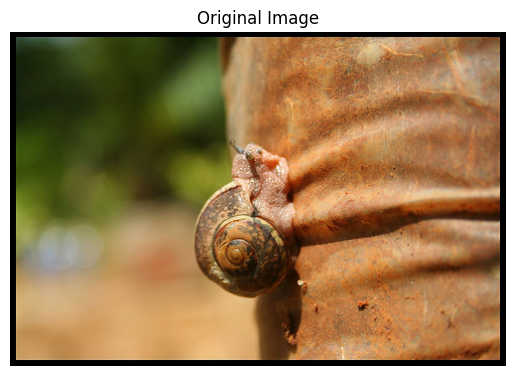

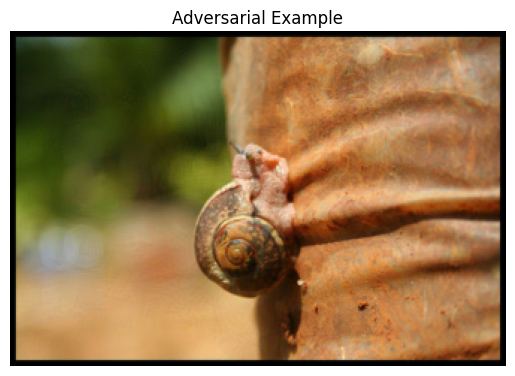

True label:  113: 'snail',
Adversarial label:  500: 'cliff dwelling',


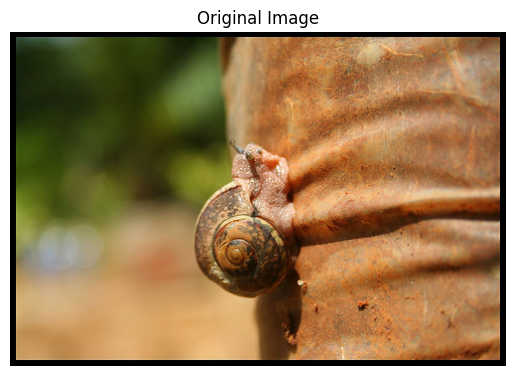

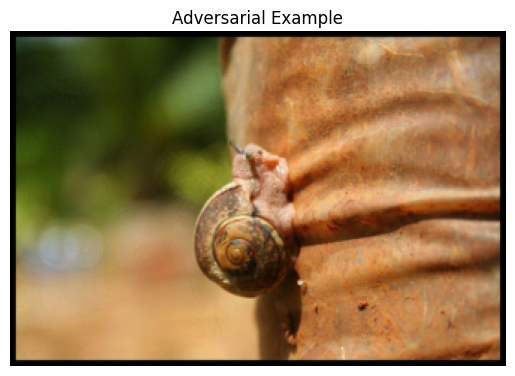

True label:  113: 'snail',
Adversarial label:  550: 'espresso maker',


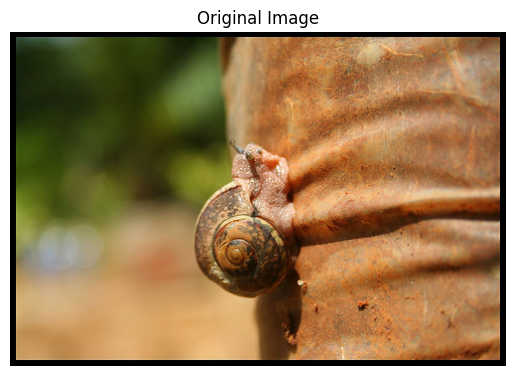

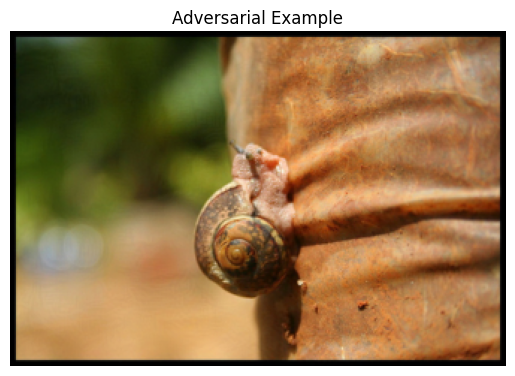

True label:  113: 'snail',
Adversarial label:  700: 'paper towel',


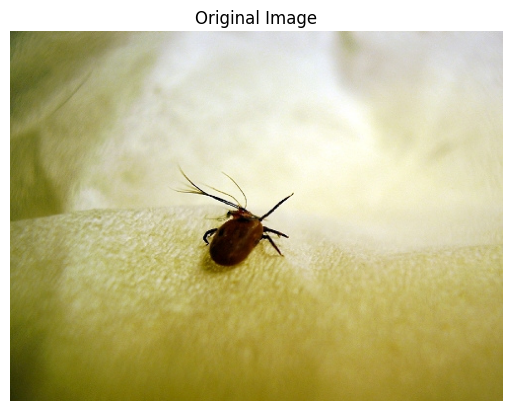

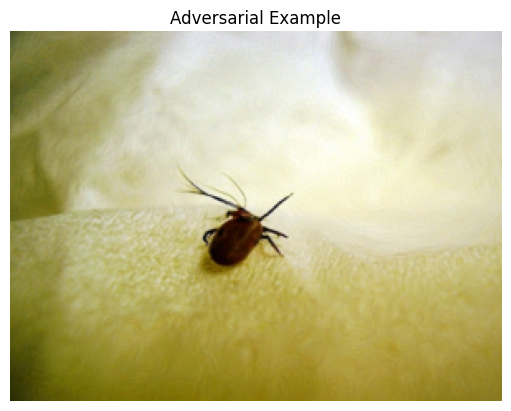

True label:  78: 'tick',
Adversarial label:  600: 'hook, claw',


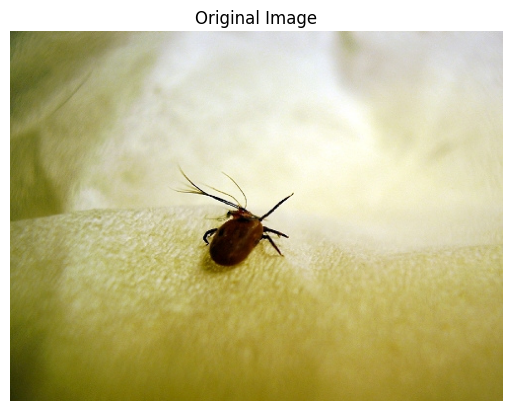

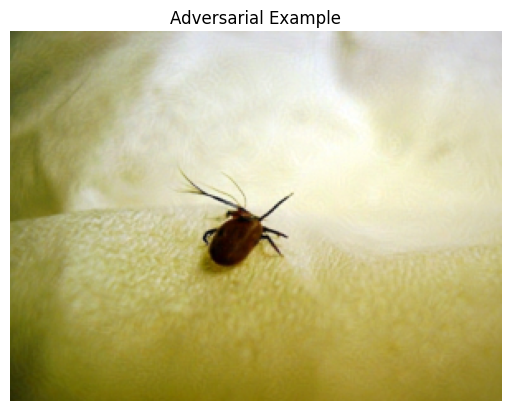

True label:  78: 'tick',
Adversarial label:  650: 'microphone, mike',


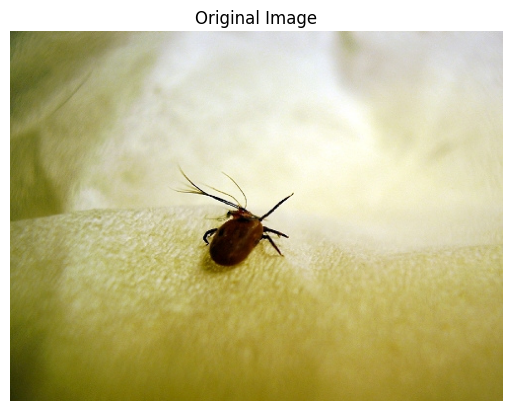

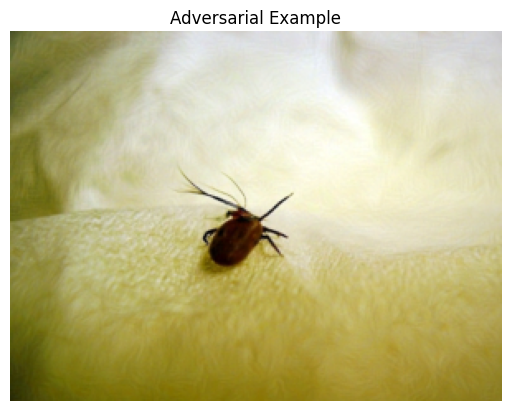

True label:  78: 'tick',
Adversarial label:  750: 'quilt, comforter, comfort, puff',


In [195]:
import torch.optim as optim
import numpy as np
import random
from torchvision.transforms.functional import to_pil_image

def unnormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
    unnormalized_tensor = tensor * std + mean
    return unnormalized_tensor

def tensor_to_image(tensor):
    unnormalized_tensor = unnormalize(tensor)
    return to_pil_image(unnormalized_tensor.clamp(0, 1))

# Define the objective function
def objective(r, alpha, model_output, target):
    l1_norm = torch.norm(r, 1)
    loss = torch.nn.functional.cross_entropy(model_output, target)
    return alpha * l1_norm + loss

# Function to create an adversarial example
def adversarial_example(image_tensor, model, true_class, target_class, alpha, learning_rate=0.01, max_iter=300):
    r = torch.zeros_like(image_tensor, requires_grad=True, device='cuda')
    optimizer = optim.Adam([r], lr=learning_rate)
    
    for i in range(max_iter):
        model_output = model(image_tensor + r)
        _, predicted_class = torch.max(model_output, 1)
        if predicted_class.item() == target_class:
            break

        optimizer.zero_grad()
        loss = objective(r, alpha, model_output, torch.tensor([target_class], device='cuda'))
        loss.backward()
        optimizer.step()
        
    return image_tensor + r

# Select two random images and three alternative classes for each
random_image_paths = random.sample(image_paths, k=2)
target_classes = [[500, 550, 700], [600, 650, 750]]

# Create adversarial examples for each image
model.to('cuda')
adversarial_examples = []
for i, image_path in enumerate(random_image_paths):
    image_tensor = preprocess(Image.open(BytesIO(requests.get(image_path).content))).unsqueeze(0).to('cuda')
    true_class = torch.argmax(model(image_tensor)).item()
    for target_class in target_classes[i]:
        adv_example = adversarial_example(image_tensor, model, true_class, target_class, alpha=0.001)
        adversarial_examples.append((image_path, adv_example))

# Visualize original and adversarial examples and labels found by AlexNet
for image_path, adv_example in adversarial_examples:
    # Show original image
    original_image = Image.open(BytesIO(requests.get(image_path).content))
    plt.imshow(original_image)
    plt.axis("off")
    plt.title("Original Image")
    plt.show()

    # Show adversarial example 
    adv_image = tensor_to_image(adv_example.squeeze(0).detach().cpu())
    plt.imshow(adv_image)
    plt.axis("off")
    plt.title("Adversarial Example")
    plt.show()

    # Print labels found by AlexNet for original and adversarial images
    model.to('cpu')
    true_label, _ = classify_image(original_image)
    print("True label:", true_label)
    adv_label, _ = classify_image(adv_example.cpu(), preprocess_=False)
    print("Adversarial label:", adv_label)

In [199]:
%reset
import torch
import torch.nn as nn

# Position-wise Feedforward Network using nn.Linear
class PositionwiseFeedforwardLinear(nn.Module):
    def __init__(self, d_model):
        super(PositionwiseFeedforwardLinear, self).__init__()
        self.fc1 = nn.Linear(d_model, d_model)

    def forward(self, x):
        return torch.relu(self.fc1(x))


# Position-wise Feedforward Network using nn.Conv1d
class PositionwiseFeedforwardConv1d(nn.Module):
    def __init__(self, d_model):
        super(PositionwiseFeedforwardConv1d, self).__init__()
        self.conv1 = nn.Conv1d(d_model, d_model, kernel_size=1)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = torch.relu(self.conv1(x))
        return x.permute(0, 2, 1)
    
# Create random input tensor Z with size (B, T, D)
B, T, D = 5, 10, 64
Z = torch.rand(B, T, D)

# Instantiate the Position-wise Feedforward Network layers
pwff_linear = PositionwiseFeedforwardLinear(D)
pwff_conv1d = PositionwiseFeedforwardConv1d(D)


def copy_parameters(src_model, dest_model):
    for src_param, dest_param in zip(src_model.parameters(), dest_model.parameters()):
        dest_param.squeeze().data.copy_(src_param.squeeze().data)

copy_parameters(pwff_conv1d, pwff_linear)

    
# Forward pass
out_linear = pwff_linear(Z)
out_conv1d = pwff_conv1d(Z)

# Validate the implementations match
assert torch.allclose(out_linear, out_conv1d, atol=1e-5), "Implementations do not match"
print("Match!")

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Match!
